<a href="https://colab.research.google.com/github/vigneshwaran5803/colab/blob/main/plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os

# ===================== RESNET18 =====================

class BasicBlock(nn.Module):
    """
    Residual Block cơ bản của ResNet
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        # Conv layer 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Conv layer 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample để khớp kích thước cho skip connection
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        # Conv block 1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Conv block 2
        out = self.conv2(out)
        out = self.bn2(out)

        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Residual connection
        out = self.relu(out)

        return out


class ResNet18(nn.Module):
    """
    Kiến trúc ResNet18 hoàn chỉnh cho phân loại bệnh trên lá cây
    """
    def __init__(self, num_classes=38):
        super(ResNet18, self).__init__()

        self.in_channels = 64

        # Conv layer đầu tiên
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 4 residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Adaptive average pooling và fully connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        # Khởi tạo trọng số
        self._initialize_weights()

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None

        # Nếu stride != 1 hoặc số channel thay đổi, cần downsample
        if stride != 1 or self.in_channels != out_channels * BasicBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * BasicBlock.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion),
            )

        layers = []
        # Block đầu tiên có thể thay đổi kích thước
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock.expansion

        # Các block còn lại
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Khởi tạo trọng số cho mạng"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Conv layer đầu
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pooling và classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# ===================== data & dataloader =====================

# Đường dẫn dataset
data_dir = '/content/dataset'

# Transform cho training với data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Thêm rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Thêm color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transform cho validation
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# Chia train/val/test: 70% train, 20% val, 10% test
# Bước 1: Chia thành train (70%) và temp (30%)
train_idx, temp_idx = train_test_split(range(len(full_dataset)), test_size=0.3, stratify=full_dataset.targets)

# Bước 2: Chia temp thành val (20%) và test (10%)
# temp có 30%, cần chia thành 20% và 10% của tổng dataset
# 20%/30% = 2/3 và 10%/30% = 1/3
val_idx, test_idx = train_test_split(temp_idx, test_size=1/3, stratify=[full_dataset.targets[i] for i in temp_idx])

# Tạo datasets
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

# Áp dụng transform phù hợp cho từng dataset
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Kích thước datasets:")
print(f"  Train: {len(train_dataset)} samples ({len(train_dataset)/len(full_dataset)*100:.1f}%)")
print(f"  Validation: {len(val_dataset)} samples ({len(val_dataset)/len(full_dataset)*100:.1f}%)")
print(f"  Test: {len(test_dataset)} samples ({len(test_dataset)/len(full_dataset)*100:.1f}%)")

num_classes = len(full_dataset.classes)  # 38 classes

# ===================== KHỞI TẠO MÔ HÌNH =====================

# Tạo mô hình ResNet18 custom từ đầu
model = ResNet18(num_classes=num_classes)

# Chuyển mô hình sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Đang sử dụng device: {device}")
print(f"Số lượng classes: {num_classes}")
print(f"Tổng số parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Số parameters có thể train: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Train toàn bộ mạng

# Learning rate scheduler để giảm learning rate theo epoch
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ===================== HUẤN LUYỆN MÔ HÌNH =====================

epochs = 50  # Tăng số epoch vì có early stopping
best_accuracy = 0.0
patience = 7  # Số epoch chờ đợi trước khi dừng sớm
patience_counter = 0  # Đếm số epoch không cải thiện

print("\n" + "="*50)
print("BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH")
print(f"Early Stopping Patience: {patience} epochs")
print("="*50 + "\n")

for epoch in range(epochs):
    # ========== TRAINING PHASE ==========
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass và optimization
        loss.backward()
        optimizer.step()

        # Tính toán accuracy cho training
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        # In progress mỗi 50 batches
        if (batch_idx + 1) % 50 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    train_accuracy = 100 * train_correct / train_total
    avg_train_loss = running_loss / len(train_loader)

    # ========== VALIDATION PHASE ==========
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # In kết quả epoch
    print(f'\n{"="*70}')
    print(f'Epoch [{epoch+1}/{epochs}] Summary:')
    print(f'  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%')
    print(f'  Val Loss: {avg_val_loss:.4f}   | Val Acc: {val_accuracy:.2f}%')
    print(f'  Learning Rate: {current_lr:.6f}')
    print(f'{"="*70}\n')

    # Lưu model tốt nhất và kiểm tra early stopping
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        patience_counter = 0  # Reset counter khi có cải thiện
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
            'num_classes': num_classes,
        }, '/content/best_plant_model.pth')
        print(f'✓ Đã lưu model tốt nhất với accuracy: {best_accuracy:.2f}%\n')
    else:
        patience_counter += 1
        print(f'⚠ Không cải thiện trong {patience_counter}/{patience} epochs\n')

        # Kiểm tra early stopping
        if patience_counter >= patience:
            print(f'\n{"="*50}')
            print(f"EARLY STOPPING ĐƯỢC KÍCH HOẠT!")
            print(f"Không cải thiện trong {patience} epochs liên tiếp")
            print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
            print(f"Dừng tại epoch {epoch+1}/{epochs}")
            print("="*50)
            break

# Lưu model cuối cùng
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_accuracy': val_accuracy,
    'num_classes': num_classes,
}, '/content/final_plant_model.pth')

print("\n" + "="*50)
print("HOÀN THÀNH HUẤN LUYỆN!")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
print("="*50)

Kích thước datasets:
  Train: 28893 samples (70.0%)
  Validation: 8255 samples (20.0%)
  Test: 4128 samples (10.0%)
Đang sử dụng device: cuda
Số lượng classes: 2
Tổng số parameters: 11,177,538
Số parameters có thể train: 11,177,538

BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH
Early Stopping Patience: 7 epochs



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Epoch [1/50], Batch [50/903], Loss: 0.6962
  Epoch [1/50], Batch [100/903], Loss: 0.6897
  Epoch [1/50], Batch [150/903], Loss: 0.6669
  Epoch [1/50], Batch [200/903], Loss: 0.6975
  Epoch [1/50], Batch [250/903], Loss: 0.6966
  Epoch [1/50], Batch [300/903], Loss: 0.6976
  Epoch [1/50], Batch [350/903], Loss: 0.7085
  Epoch [1/50], Batch [400/903], Loss: 0.6875
  Epoch [1/50], Batch [450/903], Loss: 0.7095
  Epoch [1/50], Batch [500/903], Loss: 0.6841
  Epoch [1/50], Batch [550/903], Loss: 0.6945
  Epoch [1/50], Batch [600/903], Loss: 0.6904
  Epoch [1/50], Batch [650/903], Loss: 0.6961
  Epoch [1/50], Batch [700/903], Loss: 0.6871
  Epoch [1/50], Batch [750/903], Loss: 0.6864
  Epoch [1/50], Batch [800/903], Loss: 0.6946
  Epoch [1/50], Batch [850/903], Loss: 0.7059
  Epoch [1/50], Batch [900/903], Loss: 0.6927

Epoch [1/50] Summary:
  Train Loss: 0.6994 | Train Acc: 50.00%
  Val Loss: 0.6940   | Val Acc: 49.85%
  Learning Rate: 0.001000

✓ Đã lưu model tốt nhất với accuracy: 49.85

In [22]:

print("\n" + "="*50)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*50)

# Load model tốt nhất để đánh giá
checkpoint = torch.load('/content/best_plant_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"\nKẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%")
print(f"  Best Validation Accuracy: {best_accuracy:.2f}%")
print(f"  Difference (Test - Val): {test_accuracy - best_accuracy:.2f}%")

print("="*50)


ĐÁNH GIÁ TRÊN TEST SET


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG:
  Test Loss: 0.6932
  Test Accuracy: 49.32%
  Best Validation Accuracy: 50.03%
  Difference (Test - Val): -0.71%



VISUALIZE CÁC MẪU TRONG TEST SET
Đang visualize các mẫu từ test set...


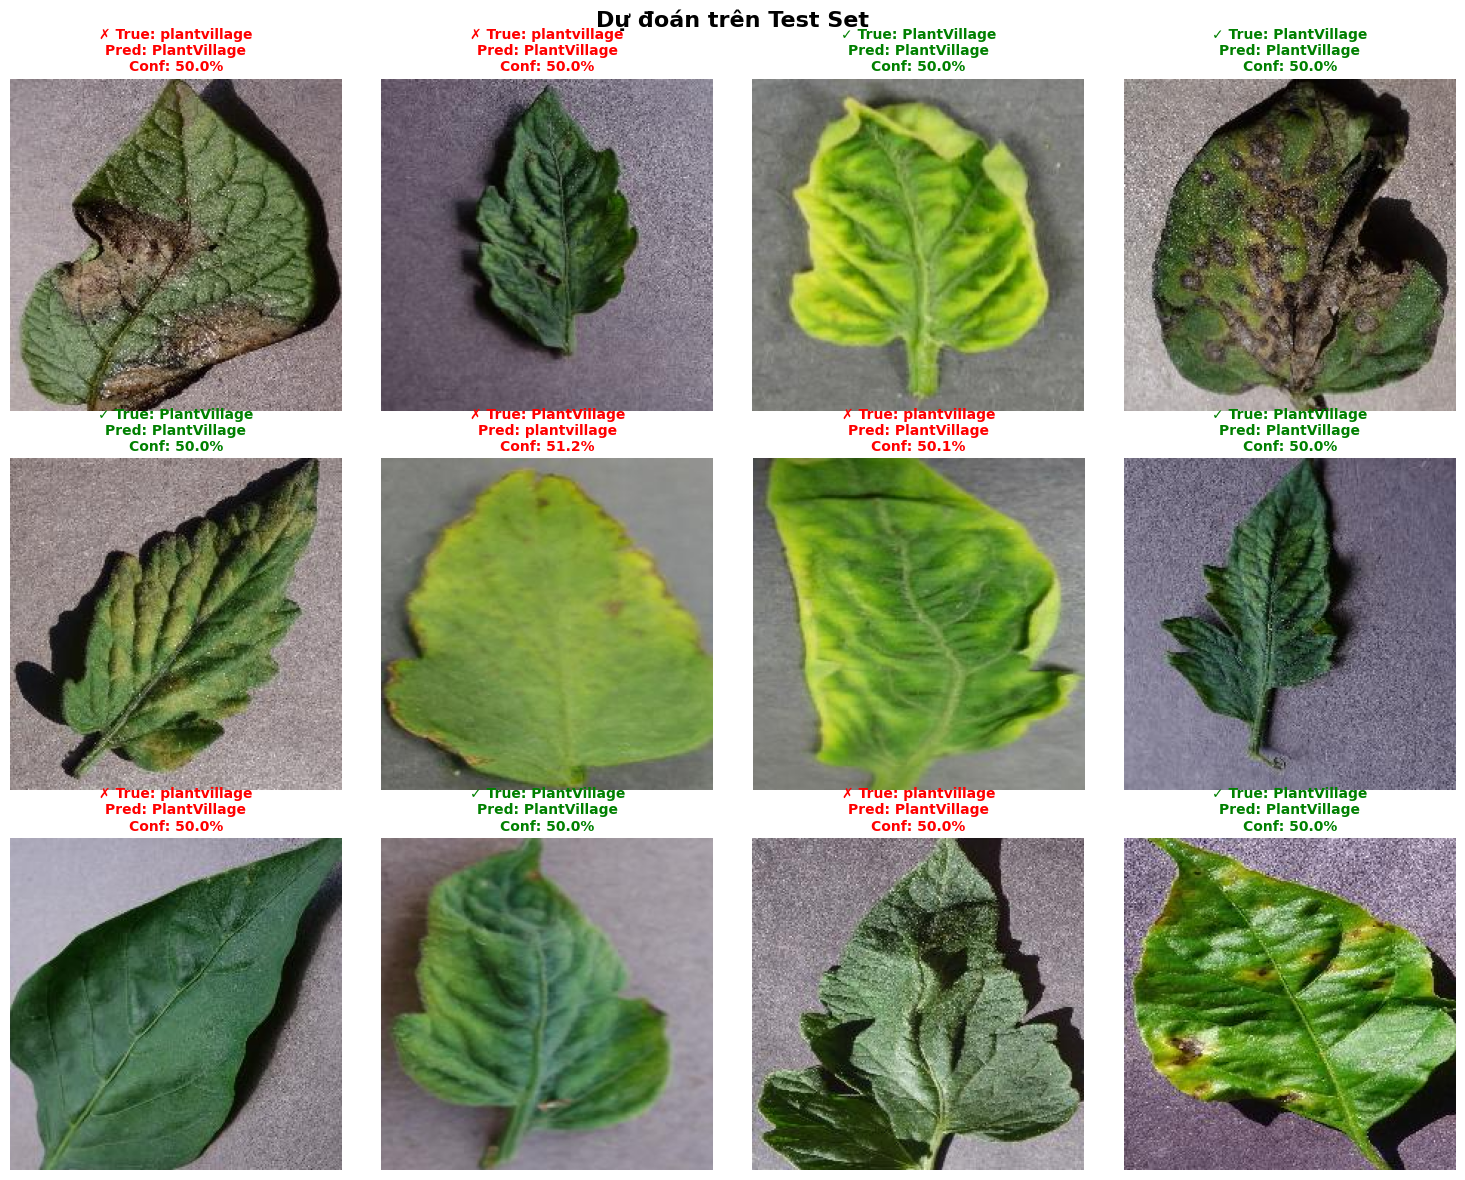


PHÂN TÍCH CÁC DỰ ĐOÁN SAI
Tổng số mẫu test: 4128
Số dự đoán đúng: 2036
Số dự đoán sai: 2092
Accuracy: 49.32%

Top 5 dự đoán sai có confidence cao nhất:
1. True: PlantVillage -> Pred: plantvillage (Conf: 52.6%)
2. True: PlantVillage -> Pred: plantvillage (Conf: 52.4%)
3. True: PlantVillage -> Pred: plantvillage (Conf: 52.0%)
4. True: PlantVillage -> Pred: plantvillage (Conf: 52.0%)
5. True: PlantVillage -> Pred: plantvillage (Conf: 51.6%)


In [23]:
import matplotlib.pyplot as plt
import numpy as np


print("\n" + "="*50)
print("VISUALIZE CÁC MẪU TRONG TEST SET")
print("="*50)

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Chuyển đổi tensor đã normalize về hình ảnh gốc"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def visualize_predictions(model, test_loader, class_names, device, num_samples=12):
    """Visualize một số mẫu từ test set với dự đoán"""
    model.eval()

    # Lấy một batch từ test loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Dự đoán
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Chuyển về CPU và denormalize
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()

    # Tạo subplot
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    fig.suptitle('Dự đoán trên Test Set', fontsize=16, fontweight='bold')

    for i in range(min(num_samples, len(images))):
        row = i // 4
        col = i % 4

        # Denormalize hình ảnh
        img = denormalize(images[i].clone())
        img = img.permute(1, 2, 0).numpy()

        # Hiển thị hình ảnh
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

        # Màu sắc cho text
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i]]
        confidence = probabilities[i][predicted[i]].item() * 100

        if labels[i] == predicted[i]:
            color = 'green'
            status = '✓'
        else:
            color = 'red'
            status = '✗'

        # Thông tin dự đoán
        axes[row, col].set_title(
            f'{status} True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
            fontsize=10,
            color=color,
            fontweight='bold'
        )

    # Ẩn các subplot không sử dụng
    for i in range(num_samples, 12):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Lấy tên các classes
class_names = full_dataset.classes

# Visualize predictions
print("Đang visualize các mẫu từ test set...")
visualize_predictions(model, test_loader, class_names, device, num_samples=12)

# Thống kê thêm về các dự đoán sai
print("\n" + "="*30)
print("PHÂN TÍCH CÁC DỰ ĐOÁN SAI")
print("="*30)

model.eval()
wrong_predictions = []
correct_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if labels[i] != predicted[i]:
                wrong_predictions.append({
                    'true_class': class_names[labels[i].item()],
                    'pred_class': class_names[predicted[i].item()],
                    'confidence': torch.nn.functional.softmax(outputs[i], dim=0)[predicted[i]].item()
                })
            else:
                correct_predictions.append({
                    'true_class': class_names[labels[i].item()],
                    'confidence': torch.nn.functional.softmax(outputs[i], dim=0)[predicted[i]].item()
                })

print(f"Tổng số mẫu test: {len(wrong_predictions) + len(correct_predictions)}")
print(f"Số dự đoán đúng: {len(correct_predictions)}")
print(f"Số dự đoán sai: {len(wrong_predictions)}")
print(f"Accuracy: {len(correct_predictions)/(len(wrong_predictions) + len(correct_predictions))*100:.2f}%")

if wrong_predictions:
    print(f"\nTop 5 dự đoán sai có confidence cao nhất:")
    wrong_predictions.sort(key=lambda x: x['confidence'], reverse=True)
    for i, pred in enumerate(wrong_predictions[:5]):
        print(f"{i+1}. True: {pred['true_class']} -> Pred: {pred['pred_class']} (Conf: {pred['confidence']*100:.1f}%)")

print("="*50)

In [24]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_accuracy': best_accuracy,
    'num_classes': num_classes,
}, '/content/best_plant_model.pth')


In [25]:
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_accuracy': val_accuracy,
    'num_classes': num_classes,
}, '/content/final_plant_model.pth')


In [27]:
import torch
# from your_model_file import ResNet18  # Import your ResNet18 class - Removed incorrect import

# Make sure to run the cell defining the ResNet18 class first

# 1️⃣ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2️⃣ Create the model architecture
# num_classes is already defined from the previous training cell
model = ResNet18(num_classes=num_classes)

# 3️⃣ Load saved weights
checkpoint = torch.load('/content/best_plant_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# 4️⃣ Set model to evaluation mode
model.eval()
model.to(device)

print(f"Model loaded! Best Validation Accuracy: {checkpoint['best_accuracy']:.2f}%")

Model loaded! Best Validation Accuracy: 50.03%


In [32]:
from PIL import Image
from torchvision import transforms

# Transform same as validation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load image
image_path = '/content/dataset/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(device)

# Predict
with torch.no_grad():
    outputs = model(image)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence, predicted_class = torch.max(probabilities, 1)

print(f"Predicted Class: {predicted_class.item()} with Confidence: {confidence.item()*100:.2f}%")


Predicted Class: 1 with Confidence: 50.68%
